In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense
import seaborn as sns

In [19]:
# Read in the variables only dataset
data = pd.read_csv('NYpropertydataVariablesUpdated.csv')

In [20]:
# Verify we have the right dataset
data.head()

,r1,r2,r3,r4,r5,r6,r7,r8,r9,r1_zip5,...,r1_boro,r2_boro,r3_boro,r4_boro,r5_boro,r6_boro,r7_boro,r8_boro,r9_boro,RECORD
0,40.917782,3781.487225,694.237107,8.079350,746.667022,137.079388,18.413002,1701.669251,312.406698,0.100365,...,0.115040,6.906445,5.079761,0.238229,11.898251,6.281489,0.199588,11.907976,9.364705,1
1,53616.895011,34245.431036,6287.063144,3959.018409,2528.648700,464.230514,24127.602755,15410.443966,2829.178415,131.514300,...,150.743329,62.545284,46.002691,116.736206,40.294395,21.272775,261.531359,107.839517,84.807469,2
2,261.796157,261.796157,87.265386,97.551991,97.551991,32.517330,117.808271,117.808271,39.269424,0.642147,...,0.736037,0.478140,0.638524,2.876433,1.554506,1.490065,1.276984,0.824401,1.177140,3
3,89.714219,836.980890,418.490445,34.913021,325.717946,162.858973,40.371399,376.641401,188.320700,0.220056,...,0.252231,1.528648,3.062111,1.029451,5.190364,7.462806,0.437606,2.635669,5.645102,4
4,669.074647,53676.325646,53676.325646,297.434763,23861.620343,23861.620343,301.083591,24154.346541,24154.346541,1.641141,...,1.881096,98.033545,392.751808,8.770206,380.238484,1093.428521,3.263598,169.027775,724.050838,5


In [21]:
# Makes copy of original data
data_orig = data.copy()

# Drops Record column prior to PCA
data.drop(columns='RECORD', inplace=True)

# Computes z scores of all data values
data = (data - data.mean()) / data.std()

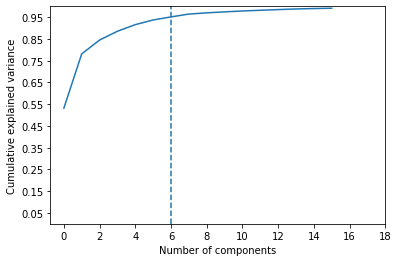

In [22]:
# initilizes PCA model
pca = PCA(n_components = .99, svd_solver = 'full')
# Fits data
pca.fit(data)

# Plots PCA explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.yticks(np.arange(0.05, 1.1, step=.1))
plt.xticks(np.arange(0, 20, step=2))
plt.axvline(x=6, linestyle='--')
plt.ylim(0,1);

In [23]:
# Intilizes PCA 
pca = PCA(n_components = 6)
princ_comps = pca.fit_transform(data)

# stores new PCA values into dataframe
data_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
data_pca.shape

(1070994, 6)

In [24]:
# Z-scale PCA values
pca_mean = data_pca.mean()
pca_sd = data_pca.std()
data_pca = (data_pca - pca_mean) / pca_sd

# Print quick description of data table
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06,1.070994e+06
mean,7.343686e-17,-2.081774e-15,7.112935e-16,5.563868e-15,-4.433786e-15,-4.401891e-16
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.473123e-01,-3.121770e+02,-4.693497e+02,-1.839580e+02,-3.911585e+02,-2.618051e+02
25%,-6.862403e-02,-9.947863e-02,-6.131604e-02,-1.448078e-01,-1.114986e-01,-7.018176e-02
50%,-1.944495e-02,-4.105365e-02,1.099320e-02,-2.396823e-02,-5.630883e-02,7.519020e-04
75%,1.192503e-02,2.033200e-02,1.500593e-01,5.505628e-02,3.222910e-02,1.235231e-01
max,5.229280e+02,6.036698e+02,6.141779e+02,3.898520e+02,4.478939e+02,4.230687e+02


In [25]:
# Set power
p=2
one_over_p = 1/p

# Compute the euclidean distance and sum values for the PCA fields
score1 = (((data_pca).abs()**p).sum(axis=1))**one_over_p

In [26]:
# placeholder for input
data_in = Input(shape=(6,))
# dimension of the encoded data. Choose 3
encoded_dim = 3
# encoded representation of the data
encoded = Dense(encoded_dim, activation='tanh')(data_in)
# reconstruction of the input
decoded = Dense(6,activation='tanh')(encoded)
# this model maps the input data to the reconstructed data
autoencoder = Model(data_in, decoded)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=5, shuffle=True, validation_data=(data_pca,data_pca))

pca_out = autoencoder.predict(data_pca)
error = pca_out - data_pca

p=2
oop=1/p

# Computes the second fraud score from the autoencoder
score2 = ((error.abs()**p).sum(axis=1))**oop

Epoch 1/5
33469/33469 [==============================] - 22s 662us/step - loss: 0.9356 - val_loss: 0.9290
Epoch 2/5
33469/33469 [==============================] - 22s 650us/step - loss: 0.9280 - val_loss: 0.9272
Epoch 3/5
33469/33469 [==============================] - 22s 659us/step - loss: 0.9270 - val_loss: 0.9266
Epoch 4/5
33469/33469 [==============================] - 24s 710us/step - loss: 0.9264 - val_loss: 0.9266
Epoch 5/5
33469/33469 [==============================] - 23s 692us/step - loss: 0.9264 - val_loss: 0.9264


In [27]:
# Stores scoring values into dataframe 
scores = pd.DataFrame(data_orig['RECORD'])
scores['score1'] = score1
scores['score2'] = score2

# Rank Binning of Scores
scores['score1 rank'] = scores['score1'].rank()
scores['score2 rank'] = scores['score2'].rank()

# Finds the 'final score' based on a rank binning
scores['final'] = (scores['score1 rank'] + scores['score2 rank'])/2

# Stores top 20 scores indexes 
top_records = scores.sort_values(['final'], ascending = False).head(100).index

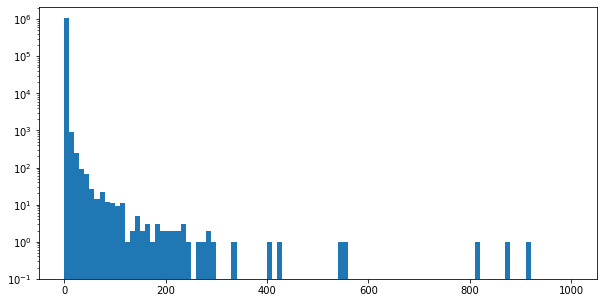

In [28]:
# Plots the distribution of the first score
plt.figure(figsize=(10,5))
plt.hist(score1, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1);

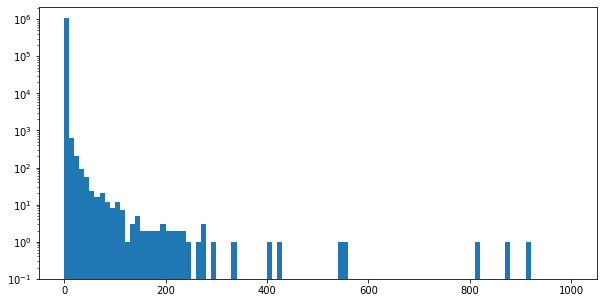

In [29]:
# Plots the distribution of the second score
plt.figure(figsize=(10,5))
plt.hist(score2, bins=100, range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1);

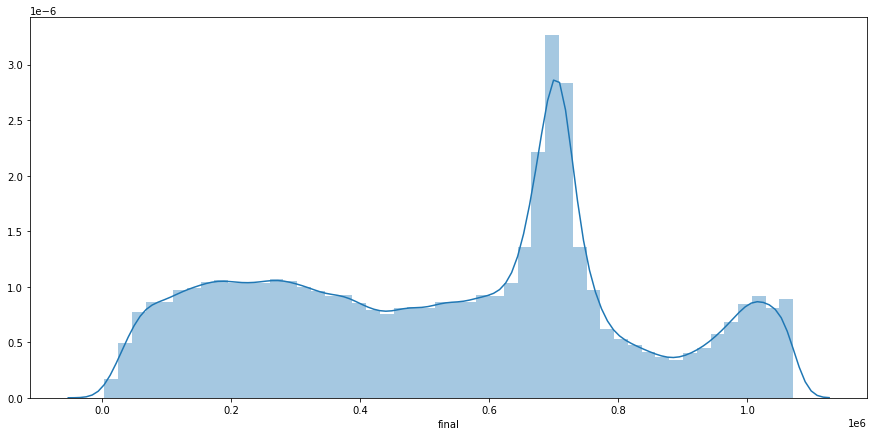

In [30]:
# Plots the density distribution of the third score 
plt.figure(figsize=(15,7))
sns.distplot(scores['final'])
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,2.5))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,1.0))

In [31]:
original_data = pd.read_csv('NY property data.csv')

In [32]:
# Merges the original dataframe with the variables dataframe
data['RECORD'] = data_orig['RECORD']

# subsets for only the top 20 scored observations
best = original_data.loc[list(top_records)]
subset = scores.loc[list(top_records), ['RECORD', 'score1 rank', 'score2 rank', 'final']]
returned = best.merge(subset, how = 'outer', on = 'RECORD')

In [33]:
returned.head(20)

,RECORD,BBLE,B,BLOCK,LOT,EASEMENT,OWNER,BLDGCL,TAXCLASS,LTFRONT,...,AVTOT2,EXLAND2,EXTOT2,EXCD2,PERIOD,YEAR,VALTYPE,score1 rank,score2 rank,final
0,917942,4142600001,4,14260,1,NaN,"LOGAN PROPERTY, INC.",T1,4,4910,...,4.501180e+09,1.644454e+09,4.501180e+09,NaN,FINAL,2010/11,AC-TR,1070994.0,1070994.0,1070994.0
1,565392,3085900700,3,8590,700,NaN,U S GOVERNMENT OWNRD,V9,4,117,...,8.484847e+08,8.484847e+08,8.484847e+08,NaN,FINAL,2010/11,AC-TR,1070993.0,1070993.0,1070993.0
2,85886,1012540010,1,1254,10,NaN,PARKS AND RECREATION,Q1,4,4000,...,2.826018e+07,2.813400e+07,2.826018e+07,NaN,FINAL,2010/11,AC-TR,1070992.0,1070992.0,1070992.0
3,67129,1011110001,1,1111,1,NaN,CULTURAL AFFAIRS,Q1,4,840,...,2.465055e+09,2.371005e+09,2.465055e+09,NaN,FINAL,2010/11,AC-TR,1070991.0,1070991.0,1070991.0
4,684704,4036590105,4,3659,105,NaN,W RUFERT,V0,1B,2,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070990.0,1070990.0,1070990.0
5,690833,4038660070,4,3866,70,NaN,PARKS AND RECREATION,Q1,4,610,...,1.024200e+08,9.702000e+07,1.024200e+08,NaN,FINAL,2010/11,AC-TR,1070989.0,1070989.0,1070989.0
6,915469,4141400001,4,14140,1,NaN,UNITED STATES OF AMER,V0,1B,999,...,NaN,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070988.0,1070988.0,1070988.0
7,44248,1008520001,1,852,1,NaN,PARKS AND RECREATION,Q1,4,420,...,7.490385e+07,7.115760e+07,7.490385e+07,NaN,FINAL,2010/11,AC-TR,1070987.0,1070987.0,1070987.0
8,565398,3085910100,3,8591,100,NaN,DEPT OF GENERAL SERVI,V9,4,466,...,4.352642e+08,4.352642e+08,4.352642e+08,NaN,FINAL,2010/11,AC-TR,1070986.0,1070986.0,1070986.0
9,39770,1007980066,1,798,66,NaN,GREENHORN DEVELOPMENT,D9,2,75,...,4.525800e+06,NaN,NaN,NaN,FINAL,2010/11,AC-TR,1070985.0,1070985.0,1070985.0


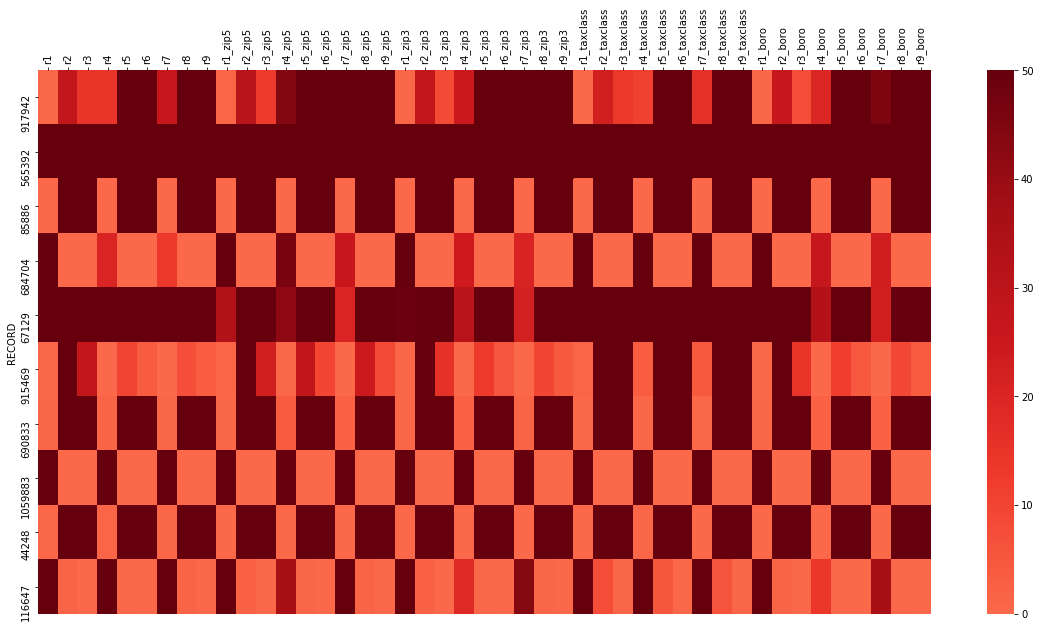

In [23]:
top_data = data.loc[list(top_records)]
top_data['RECORD'] = (top_data.index + 1).astype(int)
top_data.set_index('RECORD',inplace=True)
top_data = top_data.abs()
data_heatmap = top_data.abs().head(10)
plt.rcParams['figure.figsize'] = (20,10)
ax = sns.heatmap(data_heatmap, center=0, vmin=0, vmax=50, cmap='Reds')
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.xticks(rotation=90)
plt.savefig('heatmap.png')